In [1]:
%load_ext autoreload
%autoreload 2

import uproot
import awkward as ak

import matplotlib.pylab as plt
import numpy as np

import time

from hist import Hist

import babar_analysis_tools as bat

from analysis_variables import *

import myPIDselector

import pandas as pd

In [4]:
start = time.time()

# At Siena
#topdir = '/mnt/qnap/babar_data/bnv_plambda'

##josie laptop 
#topdir = "/Users/josieswann/Desktop/important documents"

# On Bellis' laptop
#topdir = '/home/bellis/babar_data/bnv_plambda/'

# At Bellis' home
topdir = '/home/bellis/babar_data/bnv_plambda'

# On Bellis' laptop
#topdir = './'

filename = f'{topdir}/Background_and_signal_SP_modes_Only_Run_1.parquet'
#filename = f'{topdir}/Background_and_signal_SP_modes_All_runs.parquet'

data = ak.from_parquet(filename)

print(f"Took {time.time() - start} s")
IS_MC=True


'''
# Collision data
#filename = f'{topdir}/Background_SP_modes_Only_Run_1.parquet'
filename = f'{topdir}/Data_Only_Run_1_BLINDED.parquet'
#filename = f'{topdir}/Data_All_runs_BLINDED.parquet'
#filename = f'{topdir}/Data_All_runs_BLINDED.parquet'

start = time.time()

data_collision = ak.from_parquet(filename)
#data_collision = ak.from_parquet(filename)

print(f"Took {time.time() - start} s")

print(type(data_collision))
'''


Took 1.089289665222168 s


'\n# Collision data\n#filename = f\'{topdir}/Background_SP_modes_Only_Run_1.parquet\'\nfilename = f\'{topdir}/Data_Only_Run_1_BLINDED.parquet\'\n#filename = f\'{topdir}/Data_All_runs_BLINDED.parquet\'\n#filename = f\'{topdir}/Data_All_runs_BLINDED.parquet\'\n\nstart = time.time()\n\ndata_collision = ak.from_parquet(filename)\n#data_collision = ak.from_parquet(filename)\n\nprint(f"Took {time.time() - start} s")\n\nprint(type(data_collision))\n'

In [5]:
### information about cross section --> what we'll use to calculate scaling values for histograms 

dataset_information = pd.read_csv("dataset_statistics.csv")
cs_data= pd.read_csv("SP_cross_sections_and_labels.csv")

no_notes= cs_data.drop(["Uncertainty","Note: cross sections found at https://babar-wiki.heprc.uvic.ca/bbr_wiki/index.php/Physics/Cross_sections,_luminosities,_and_other_vital_stats"], axis= 1)
no_notes

,SP Mode,Human-readable explamanation,LaTeX output,Cross section [nb]
0,1235,B+B- pairs,$B^+ B^-$,0.525
1,1237,B0 B0bar pairs,$B^0\overline{B^0}$,0.525
2,1005,ccbar,$c\bar{c}$,1.300
3,998,uubar/ddbar/ssbar,"$u\bar{u}, d\bar{d}, c\bar{c}$",2.090
4,2400,bhabha- e+e- to e+e-,$e^+e^-$,40.000
5,3429,tau+tau-,$\tau^+\tau^-$,0.919
6,3981,mu+mu- gamma,$\mu^+\mu^-\gamma$,1.147


In [6]:
sp = data['spmode']

np.unique(sp.to_list())

array(['-999', '1005', '1235', '1237', '3981', '991', '998'], dtype='<U4')

In [7]:
region_definitions

{'Area': ['Fitting area', 'Signal area'],
 'signal MES': [5.27, 5.3],
 'fitting MES': [5.2, 5.3],
 'signal DeltaE': [-0.07, 0.07],
 'fitting DeltaE': [-0.2, 0.2],
 'sideband 1 DeltaE': [0.07, 0.14],
 'sideband 2 DeltaE': [-0.07, -0.14],
 'sideband MES': [5.27, 5.3],
 'Lambda0 mass': [1.112683, 1.1186829999999999],
 'Lambda0 flightlen': 1.0}

In [8]:
# Make our histograms
all_hists = bat.create_empty_histograms(hist_defs)

bkg_spmodes = ['998', '1005', '1235', '1237', '3981']
sig_spmodes = ['-999']

spmodes = bkg_spmodes + sig_spmodes

weights = {}
for sp in spmodes:
    weights[sp] = bat.scaling_value(int(sp), dataset_information=dataset_information, cs_data=cs_data, plot=False, verbose=False)
    #weights[sp] = 1

### bat.scaling_value is in Babar_analysis_tools.py 

# Scale the signal higher
weights['-999'] = 1000
weights['0'] = 1

print(weights)
print()
print(spmodes)

{'998': 0.2506879075487834, '1005': 0.49619965664110677, '1235': 0.3191592629119508, '1237': 0.31492522877218293, '3981': 0.7950555869080849, '-999': 1000, '0': 1}

['998', '1005', '1235', '1237', '3981', '-999']


signal: 1140   fit: 21027  s1: 480  s2: 618  ave(s1,s2): 549.0


IndexError: cannot slice ListArray (of length 41510) with [[0, 1], [], [], [], [], [0, 1], [], ..., [], [0, 1], [], [0, 1], [0, 1], []]: index out of range while attempting to get index 2 (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-37/awkward-cpp/src/cpu-kernels/awkward_ListArray_getitem_jagged_apply.cpp#L43)

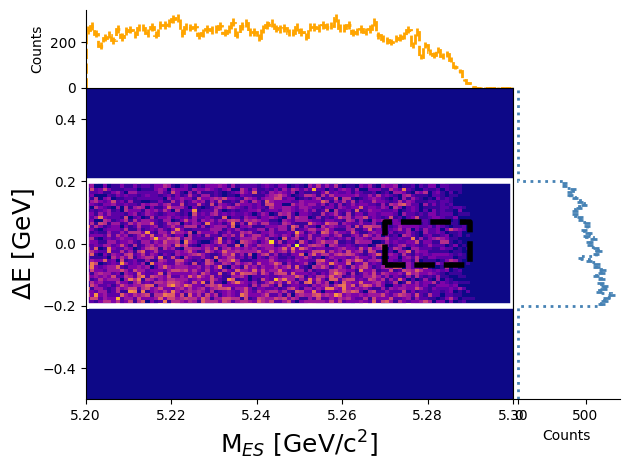

In [9]:
# Pull out some SP mode
spmode = '1005'
#spmode='998'
#spmode='991'
#spmode='-999'
#spmode='0'
#mask_sp = data['spmode'] == spmode

mask_sp = (data['spmode'] == '998') | (data['spmode'] == '1005')


# Collision data
#mask_sp = data['spmode']=='0'

# Make a subset
data_sp = data[mask_sp]

# For data we need to account for blinding
if IS_MC is False:
    nB = data_sp['nB']
    Bp3 = data_sp['Bp3']
    nBp3 = ak.num(Bp3)
    
    mask_to_account_for_blinding = nB == nBp3
    print(len(nB[mask_to_account_for_blinding]), len(nB[~mask_to_account_for_blinding]))
    
    data_sp = data_sp[mask_to_account_for_blinding]

# Use only the data in the fitting region
fit_mask = bat.get_fit_mask(data_sp, region_definitions)

# Make the plot
mes =    ak.flatten(data_sp['BpostFitMes'][fit_mask])
DeltaE = ak.flatten(data_sp['BpostFitDeltaE'][fit_mask])

bat.plot_mes_vs_DeltaE(mes, DeltaE, region_definitions=region_definitions, draw_signal_region=True)

#print(len(mes),len(DeltaE))

## Other HISTOGRAMS 
all_hists = bat.create_empty_histograms(hist_defs)
x = ak.flatten(data_sp['Lambda0_unc_Mass'][fit_mask])
weight = weights[spmode]
all_hists['Lambda0_unc_Mass'].fill(var=x, SP= spmode, cuts= f"{0}", weight= weight)

plt.figure()
all_hists['Lambda0_unc_Mass'].project('var').plot(histtype="fill", color='red', label= spmode)
all_hists['Lambda0_unc_Mass'].project('var').plot(histtype="step", color='black')
plt.legend();

In [ ]:

mask_lambda0, mask_event_nlambda0 = bat.get_lambda0_mask(data_sp, region_definitions=region_definitions, flightlenvar='Lambda0FlightLen')

# Use only the data in the fitting region
fit_mask = bat.get_fit_mask(data_sp, region_definitions)

######################################


mask_bool_proton, mask_bool_pion, mask_bool_protonB = bat.PID_masks(data_sp, \
              lamp_selector='SuperLooseKMProtonSelection', \
              lampi_selector='VeryTightKMPionMicroSelection', \
              Bp_selector='SuperTightKMProtonSelection', \
              verbosity=0)

mask_pid =      mask_bool_proton & mask_bool_pion & mask_bool_protonB

mask_event = mask_event_nlambda0
mask_candidates = fit_mask & mask_lambda0 & mask_pid 

# Make the plot
mes =    ak.flatten(data_sp[mask_event]['BpostFitMes'][mask_candidates[mask_event]])
DeltaE = ak.flatten(data_sp[mask_event]['BpostFitDeltaE'][mask_candidates[mask_event]])

######################################


bat.plot_mes_vs_DeltaE(mes, DeltaE, region_definitions=region_definitions, draw_signal_region=True, zoom=True)


In [13]:
data['Lambda0_unc_Mass']

<Array [[1.12], [1.12], ..., [1.11], [1.12]] type='101576 * var * float32'>

In [14]:
data['BpostFitMes']

<Array [[5.25, 5.25], [...], ..., [5.28, 5.28]] type='101576 * var * float32'>

PROCESSING FOR bkg ==========================
[[True], [True], [True], [True], [True], ..., [True], [False], [False], [False]]
[[True], [True], [True], [False], [True], ..., [True], [True], [True], [True]]
[[False, False], [False, False], [...], ..., [False, False], [False, False]]


ValueError: cannot broadcast nested list

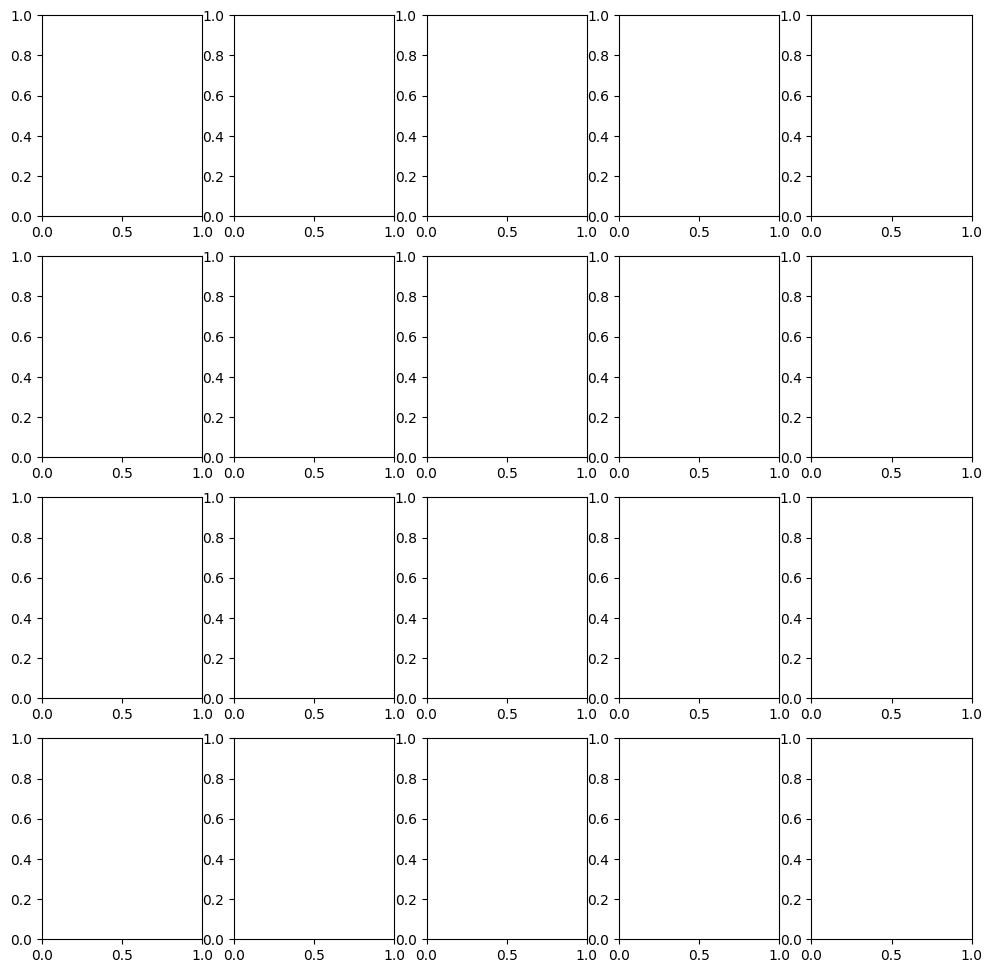

In [11]:
#'''
subset = ['BSphr', 'BThrust', 'BCosThetaS', \
          'R2', 'R2All', \
          'thrustMag', 'thrustMagAll', 'thrustCosTh', 'thrustCosThAll', 'sphericityAll', \
          'BCosSphr', 'BCosThetaT', 'BCosThrust', 'BLegendreP2', 'BR2ROE', 'BSphrROE', \
          'BThrustROE']
#'''
#subset = ['BSphr', 'BpostFitDeltaE', 'BpostFitMes', 'BThrust', 'BCosThetaS']

data_for_df = {}

# Pull out some SP mode
spmode = '1005'
#spmode='998'
#spmode='991'
#spmode='-999'
#spmode='0'
#mask_sp = data['spmode'] == spmode

mask_sp = (data['spmode'] == '998') | (data['spmode'] == '1005')


fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(12,12) )

for SIG_OR_BKG in ['bkg', 'sig']:

    mask_sp = None
    if SIG_OR_BKG=='bkg':
        mask_sp = (data['spmode'] == '998') | (data['spmode'] == '1005')
    else:
        mask_sp = (data['spmode'] == '-999')

    print(f"PROCESSING FOR {SIG_OR_BKG} ==========================")
    
    # Collision data
    #mask_sp = data['spmode']=='0'
    
    # Make a subset
    data_sp = data[mask_sp]
    
    # For data we need to account for blinding
    if IS_MC is False:
        nB = data_sp['nB']
        Bp3 = data_sp['Bp3']
        nBp3 = ak.num(Bp3)
        
        mask_to_account_for_blinding = nB == nBp3
        print(len(nB[mask_to_account_for_blinding]), len(nB[~mask_to_account_for_blinding]))
        
        data_sp = data_sp[mask_to_account_for_blinding]
    
    # Use only the data in the fitting region
    fit_mask = bat.get_fit_mask(data_sp, region_definitions)
    
    # Make the plot
    #mes =    ak.flatten(data_sp['BpostFitMes'][fit_mask])
    #DeltaE = ak.flatten(data_sp['BpostFitDeltaE'][fit_mask])
    
    #bat.plot_mes_vs_DeltaE(mes, DeltaE, region_definitions=region_definitions, draw_signal_region=True)
    
    #print(len(mes),len(DeltaE))
    
    ## Other HISTOGRAMS 
    #all_hists = bat.create_empty_histograms(hist_defs)
    #x = ak.flatten(data_sp['Lambda0_unc_Mass'][fit_mask])
    #weight = weights[spmode]
    #all_hists['Lambda0_unc_Mass'].fill(var=x, SP= spmode, cuts= f"{0}", weight= weight)
    
    #plt.figure()
    #all_hists['Lambda0_unc_Mass'].project('var').plot(histtype="fill", color='red', label= spmode)
    #all_hists['Lambda0_unc_Mass'].project('var').plot(histtype="step", color='black')
    #plt.legend();
    
    
    ################# More masks
    mask_lambda0, mask_event_nlambda0 = bat.get_lambda0_mask(data_sp, region_definitions=region_definitions, flightlenvar='Lambda0FlightLen')
    
    # Use only the data in the fitting region
    fit_mask = bat.get_fit_mask(data_sp, region_definitions)
    
    ######################################
    
    
    mask_bool_proton, mask_bool_pion, mask_bool_protonB = bat.PID_masks(data_sp, \
                  lamp_selector='SuperLooseKMProtonSelection', \
                  lampi_selector='VeryTightKMPionMicroSelection', \
                  Bp_selector='SuperTightKMProtonSelection', \
                  verbosity=0)
    print(mask_bool_proton)
    print(mask_bool_pion)
    print(mask_bool_protonB)
    
    mask_pid =      mask_bool_proton & mask_bool_pion & mask_bool_protonB
    
    #mask_event = mask_event_nlambda0
    mask_candidates = fit_mask & mask_lambda0 & mask_pid 

    npass = ak.num(mask_candidates[mask_candidates])
    
    mask_event = npass==1
    
    # Make the plot
    #mes =    ak.flatten(data_sp[mask_event]['BpostFitMes'][mask_candidates[mask_event]])
    #DeltaE = ak.flatten(data_sp[mask_event]['BpostFitDeltaE'][mask_candidates[mask_event]])
    
    ######################################
    
    
    #bat.plot_mes_vs_DeltaE(mes, DeltaE, region_definitions=region_definitions, draw_signal_region=True, zoom=True)
    
    
    #plt.figure(figsize=(12,12))
    for i,var in enumerate(subset):
        #print(var)
    
        if var[0]=='B':
            x = data_sp[mask_event][var][mask_candidates[mask_event]]
            x = ak.flatten(x)
        else:
            x = data_sp[mask_event][var]
    
        #plt.subplot(5,4,i+1)
        row = int(i/5)
        col = i%5
        #print(row, col)
        plt.sca(axes[row][col])
        alpha = 1.0
        if SIG_OR_BKG == 'sig':
            alpha=0.5

        plt.hist(x,bins=40, label=f'{SIG_OR_BKG}: {var}', density=True, alpha=alpha);

        if SIG_OR_BKG == 'sig':
            plt.legend()

        # Put it in dictionary
        if SIG_OR_BKG == 'bkg':
            data_for_df[var] = x.to_list()
            if i==0:
                data_for_df['dataset'] = np.full(len(x), SIG_OR_BKG).tolist()
        elif SIG_OR_BKG == 'sig':
            data_for_df[var] += x.to_list()
            if i==0:
                data_for_df['dataset'] += np.full(len(x), SIG_OR_BKG).tolist()


# Construct tag-side B

In [ ]:
def spherical_to_cartesian(r, costh, phi):
    
    #print(p3_spher)
    #print(costh)
    theta = np.arccos(costh)

    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)

    pmag = np.sqrt(x**2 + y**2 + z**2)
    print(pmag, r)

    return x,y,z, pmag

def mass_from_spherical(p4s_spherical):

    etot,px,py,pz = 0,0,0,0
    
    for p4s_sph in p4s_spherical:
        #print("Here")
        #print(p4s_sph, p4s_sph[1:])
        x,y,z,pmag = spherical_to_cartesian(p4s_sph[1:])
        mass = p4s_sph[0]
        e = np.sqrt(mass**2 + pmag**2)
        
        etot += e
        px += x
        py += y
        pz += z

    #print("p4: ", etot, px, py, pz)
    m2 = etot**2 - (px**2 + py**2 + pz**2)
    if m2>=0:
        return np.sqrt(m2)
    else:
        return -np.sqrt(-m2)
    



In [ ]:
def tag_side_B(data, verbose=0):
    
    if verbose:
        print("The MC and tracks for the first entry")
        idx = data['TRKMCIdx'][0]
        mclund = data['mcLund'][0]
        nTRK = data['nTRK'][0]

        print(f"nTRK: {nTRK}")
        for i,id in enumerate(idx):
            print(f"{i:2d}  {id:4d}   {mclund[id]}")
    print()

    lamd1idx = data['Lambda0d1Idx']
    lamd1Lund = data['Lambda0d1Lund']
    lamd2idx = data['Lambda0d2Idx']
    lamd2Lund = data['Lambda0d2Lund']

    TRKp3CM = data['TRKp3CM']
    TRKcosthCM = data['TRKcosthCM']
    TRKphiCM = data['TRKphiCM']

    
    if verbose:
        print(f'lamd1idx\n{lamd1idx}')
        print(f'lamd1Lund\n{lamd1Lund}')
        print(f'lamd2idx\n{lamd2idx}')
        print(f'lamd2Lund\n{lamd2Lund}')
    
    d2idx = data['Bd2Idx']
    d2Lund = data['Bd2Lund']

    if verbose:
        print()
        print(f'B d2idx\n{d2idx}')
        print(f'B d2Lund\n{d2Lund}')
        print()

    trkidx_proton = data['pTrkIdx']
    trkidx_pion = data['piTrkIdx']

    if verbose:
        print(f"# of protons: {data['np']}")
        print(f"trkidx_proton (the track index for labeled protons) \n{trkidx_proton}")
        print(f"# of pions: {data['npi']}")
        print(f"trkidx_pion (the track index for labeled pions) \n{trkidx_pion}")
 
        print()
    
    lamd1_trkidx = trkidx_proton[lamd1idx]
    lamd2_trkidx = trkidx_pion[lamd2idx]

    d2_trkidx = trkidx_proton[d2idx]

    if verbose:
        print(f"lamd1_trkidx\n{lamd1_trkidx}\n")    
        print(f"lamd2_trkidx\n{lamd2_trkidx}\n")    
        print(f"B d2_trkidx\n{d2_trkidx}\n")

    bool_proton1 = bat.indices_to_booleans(lamd1_trkidx, TRKp3CM)
    bool_pi = bat.indices_to_booleans(lamd2_trkidx, TRKp3CM)

    bool_proton2 = bat.indices_to_booleans(d2_trkidx, TRKp3CM)

    mask_tag_side_track = ~(bool_proton1 | bool_proton2 | bool_pi)
    #mask_tag_side_track = (bool_proton1 | bool_proton2 | bool_pi)

    if verbose:
        print(f"bool_proton1: {bool_proton1}")
        print(f"bool_proton2: {bool_proton2}")
        print(f"bool_pi:      {bool_pi}")
        print(f"mask all:     {mask_tag_side_track}")

    TRKxCM, TRKyCM, TRKzCM, TRKpmagCM = spherical_to_cartesian(TRKp3CM[mask_tag_side_track], TRKcosthCM[mask_tag_side_track], TRKphiCM[mask_tag_side_track])

    if verbose:
        print(f"TRKxCM: {TRKxCM}")
        print(f"TRKyCM: {TRKyCM}")
        print(f"TRKzCM: {TRKzCM}")

    TRKxCMtot = ak.sum(TRKxCM, axis=-1)
    TRKyCMtot = ak.sum(TRKyCM, axis=-1)
    TRKzCMtot = ak.sum(TRKzCM, axis=-1)

    beamE = data['eeE']
    beamx = data['eePx']
    beamy = data['eePy']
    beamz = data['eePz']
    
    print(beamE)
    
    m = np.sqrt(beamE**2 - (beamx**2 + beamy**2 + beamz**2))

    if verbose:
        print(f'beam mass: {m}')
        print(f'beam E:    {beamE}')
        print(f'beam Px:   {beamx}')
        print(f'beam Py:   {beamy}')
        print(f'beam Pz:   {beamz}')
    
    Bpseudomass = np.sqrt((m/2)**2 - (TRKxCMtot**2 + TRKyCMtot**2 + TRKzCMtot**2))

    return Bpseudomass
    
    '''

    trk_selector_map = ak_arr['pSelectorsMap']
    
    if verbose:
        print(f"qtrk\n{qtrk}\n")
        print(f"proton trk_selector_map\n{trk_selector_map}\n")
        print(f"pion   trk_selector_map\n{ak_arr['piSelectorsMap']}\n")
        print(f"kaon   trk_selector_map\n{ak_arr['KSelectorsMap']}\n")

    lamproton_selector_map = trk_selector_map[lamd1_trkidx]

    if verbose:
        print(lamproton_selector_map)
        print()
    
    bool_idx1 = indices_to_booleans(lamd1_trkidx, trk_selector_map)
    bool_idx2 = indices_to_booleans(d2_trkidx, trk_selector_map)

    if verbose:
        print(f"proton track selectors for the index of the proton from the lambda (and not that)")
        print(f"The boolean mask bool_idx1\n{bool_idx1}")
        print(trk_selector_map[bool_idx1])
        print(trk_selector_map[~bool_idx1])
        print()

        print(f"proton track selectors for the index of the proton from the B (and not that)")
        print(f"The boolean mask bool_idx1\n{bool_idx2}")
        print(trk_selector_map[bool_idx2])
        print(trk_selector_map[~bool_idx2])
        print()
        
    
        # Both protons
        print(f"Boolean for both protons (or) \n{(bool_idx1 | bool_idx2)}")
        print(f"trk selectors for both protons (or) \n{trk_selector_map[bool_idx1 | bool_idx2]}")
        print(f"trk selectors for other protons     \n{trk_selector_map[~(bool_idx1 | bool_idx2)]}")
        print()
    
    
    
    pbits = bat.calculate_bits_for_PID_selector(None, trk_selector_map)

    if verbose:
        print(f"The pbits -----------------")
        print(f'All the pbits\n{pbits}')
        print(f"bool for protons from Lambda\n{bool_idx1}")
        print(f'pbits for protons from Lambda     pbits[bool_idx1]\n{pbits[bool_idx1]}')
        print(f'pbits for protons not from Lambda pbits[~bool_idx1]\n{pbits[~bool_idx1]}')
        print()

        print(f"bool for protons from B\n{bool_idx2}")
        print(f'pbits for protons from B     pbits[bool_idx2]\n{pbits[bool_idx2]}')
        print(f'pbits for protons not from B pbits[~bool_idx2]\n{pbits[~bool_idx2]}')
        print()

        
    mask_bool = bat.mask_PID_selection(pbits, selector, pps)

    if verbose:
        print(f"mask_bool, (mask_PID_selection) the tracks that pass {selector}")
        print(mask_bool)
        print(pbits[mask_bool])
        print(pbits[~mask_bool])
        print()
        
        print(f"pbits that are not the final state lambda but are protons")
        print(pbits[~bool_idx1 & mask_bool])
        print()
        
        print(f"TRKcharge that are not the final state lambda but are protons")
        print(qtrk[~bool_idx1 & mask_bool])
        print()
    '''

    return 1

##########################################################################
# Pull out some SP mode
#spmode='1005'
#spmode='998'
#spmode='991'
spmode='-999'
#spmode='0'
mask_sp = data['spmode'] == spmode

m = tag_side_B(data[mask_sp], verbose=1)

In [ ]:
plt.figure()
plt.hist(m, bins=100, range=(4.0,5.3))
;

In [ ]:
#bool_proton1

TRKp3CM = data[mask_sp]['TRKp3CM']

print(TRKp3CM)

ak.sum(TRKp3CM, axis=-1)

In [ ]:
beamE = data['eeE']
beamx = data['eePx']
beamy = data['eePy']
beamz = data['eePz']

print(beamE)

m = np.sqrt(beamE**2 - (beamx**2 + beamy**2 + beamz**2))

print(m)

# Gammas and pi0s

In [33]:
output = ""
for f in data.fields:
    if f.find('gamma')<0:
        continue
        
    if len(output)<80:
        output += f"{f:16s} "
    else:
        print(output)
        output = f"{f:16s} "
print(output)

ngamma           gammacosth       gammacosthCM     gammaenergy      gammaenergyCM    
gammap3          gammap3CM        gammaphi         gammaphiCM       gammaLund        
gammaMCIdx       gammaLat         gammaA42         gammaECal        gammaErawCal     
gammaCentx       gammaCenty       gammaCentz       gammanCrys       


''

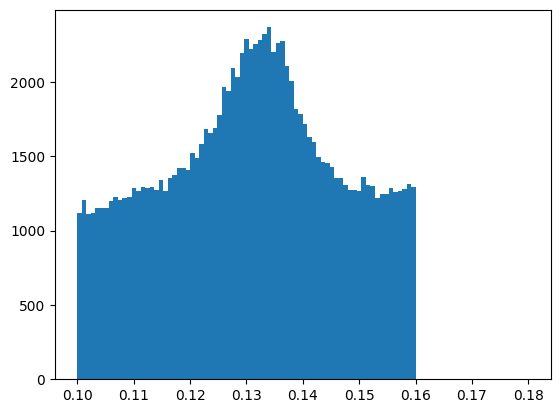

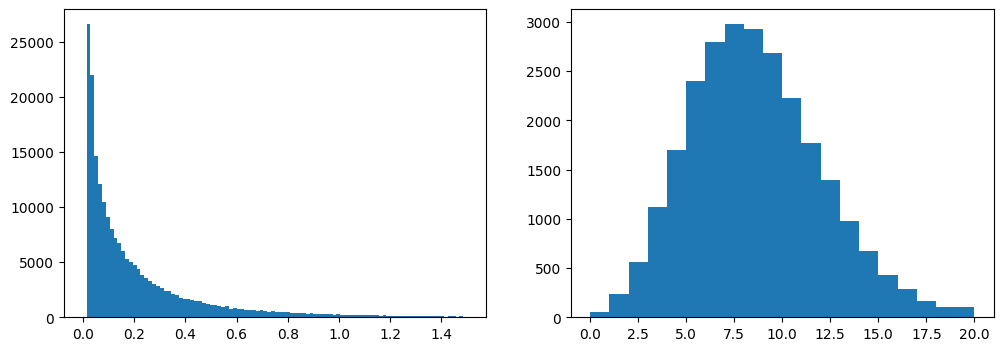

In [38]:
spmask = data['spmode']=='998'

#x = data[spmask]['pi0_unc_Mass']
x = data[spmask]['pi0Mass']

plt.figure()
plt.hist(ak.flatten(x), bins=100, range=(0.100,0.180))



plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
x = data[spmask]['gammap3']
plt.hist(ak.flatten(x), bins=100, range=(0,1.5))

plt.subplot(1,2,2)
x = data[spmask]['ngamma']
plt.hist(x, bins=20, range=(0,20))


;

In [27]:
data[spmask]['pi0d1Idx']


<Array [[4, 6], [], ..., [7, ...], [9, 11, 13, 15]] type='25647 * var * int32'>

In [29]:
data[spmask]['pi0d2Idx']


<Array [[5, 7], [], ..., [8, ...], [10, 12, 14, 16]] type='25647 * var * int32'>